In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.cross_decomposition import PLSRegression

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# prepare colors for plot
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec_m = sns.color_palette("dana", n_colors=27)


from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

# prepare colors for plot
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana_f", cmap)
phasec_f = sns.color_palette("dana_f", n_colors=27)

import colorcet as cc
fmap = cc.glasbey[0:20]
mmap = cc.glasbey[20:40]

/tmp/ipykernel_15661/130240003.py:11: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)
/tmp/ipykernel_15661/130240003.py:25: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana_f", cmap)


## data female

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_females_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

# take only first sample from each week
ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks

sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_female = pd.concat([sample,sample2])
df_female.rename(columns={'binned_age': 'age'}, inplace=True)

df_female.set_index(['age', 'mouse'], inplace=True)
df_female = df_female.query('mouse!="F4_03"')

In [6]:
# First, ensure the DataFrame is sorted by 'mouse' and 'age'
df_temp = df_female.sort_index(level=['mouse', 'age'])
# Apply the rolling window smoothing
smoothed_df = df_temp.groupby(level='mouse').apply(lambda x: x.rolling(window=3, min_periods=1).mean())
smoothed_df_female=smoothed_df.groupby(['age','mouse']).mean()

## data males

In [7]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
sample2['binned_age'] = sample2['binned_age']+0.5
df_male = pd.concat([sample,sample2])
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

In [8]:
# First, ensure the DataFrame is sorted by 'mouse' and 'age'
df_temp = df_male.sort_index(level=['mouse', 'age'])
# Apply the rolling window smoothing
smoothed_df = df_temp.groupby(level='mouse').apply(lambda x: x.rolling(window=3, min_periods=1).mean())
# Reindexing without conflicting columns
smoothed_df_male=smoothed_df.groupby(['age','mouse']).mean()

## normalized

In [9]:
# avarage per age or session
#f_df= df_female.groupby(['age','mouse']).mean()
f_df= smoothed_df_female.groupby(['age','mouse']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# avarage per age or session
#m_df= df_male.groupby(['age','mouse']).mean()
m_df= smoothed_df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [10]:
format_plots()

## umaps

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distanc

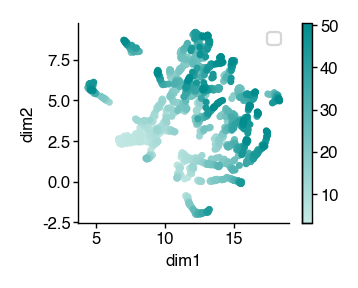

In [11]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming df contains your data
# Perform UMAP dimensionality reduction
#df = m_norm.copy()
df = m_df.copy()
reducer = umap.UMAP(random_state=0, n_neighbors=30)
umap_result = reducer.fit_transform(df)

pcs = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs['age'] = df.index.get_level_values('age')
pcs['mouse'] = df.index.get_level_values('mouse')

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.7, 1.3)

# Scatter plot
im = ax.scatter(
    x=pcs['dim1'], y=pcs['dim2'], 
    c=pcs['age'], 
    cmap=cmm,
    s=3,
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [10,20,30,40,50]
# Customize the plot
sns.despine()
#plt.title('UMAP Plot of Data')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend()
plt.show()

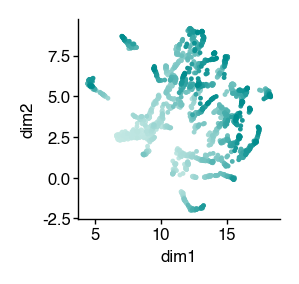

In [12]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)
im=sns.scatterplot(data=pcs, x='dim1',y='dim2',hue='age',palette=cmm, legend=False, s=3, edgecolor='none')
sns.despine()

In [13]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_male_age_longv2_n30.pdf')

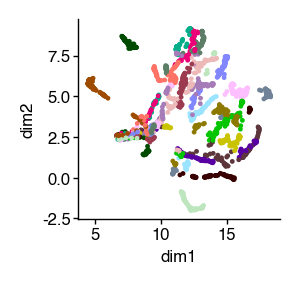

In [14]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)
im=sns.scatterplot(data=pcs, x='dim1',y='dim2',hue='mouse',palette=mmap, legend=False, s=3, edgecolor='none')
#cb = fig.colorbar(im, ax=ax)
#plt.title('UMAP Plot of Data males')
sns.despine()

In [15]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_male_indv_longv2_n30.pdf')

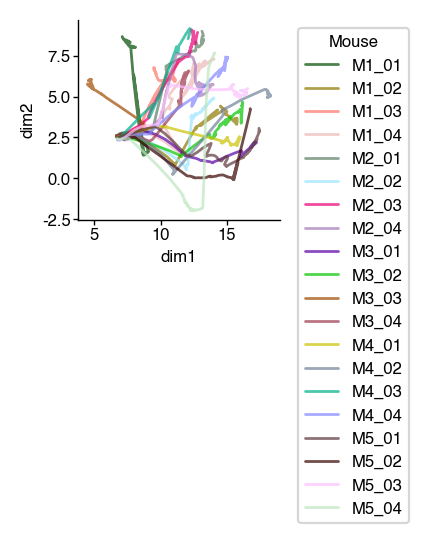

In [16]:
# Create a dictionary to map mouse IDs to colors
mouse_colors = dict(zip(pcs['mouse'].unique(), mmap))

# Set the size of the plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)

# Ensure that 'mouse' column is treated as a category for better handling
pcs['mouse'] = pcs['mouse'].astype('category')

# Apply a rolling window to smooth the data and plot lines for each mouse
for mouse_id in pcs['mouse'].unique():
    mouse_data = pcs[pcs['mouse'] == mouse_id]
    mouse_data = mouse_data.sort_values(by='age')  # Sort by 'age' for rolling window
    mouse_data['dim1_smooth'] = mouse_data['dim1'].rolling(window=4, min_periods=1).mean()
    mouse_data['dim2_smooth'] = mouse_data['dim2'].rolling(window=4, min_periods=1).mean()
    ax.plot(mouse_data['dim1_smooth'], mouse_data['dim2_smooth'], label=mouse_id, color=mouse_colors[mouse_id], alpha=0.7, linewidth=1)

# Customize the plot
sns.despine()
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend(title='Mouse', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [17]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_male_indv_longv2_n30_traj.pdf')

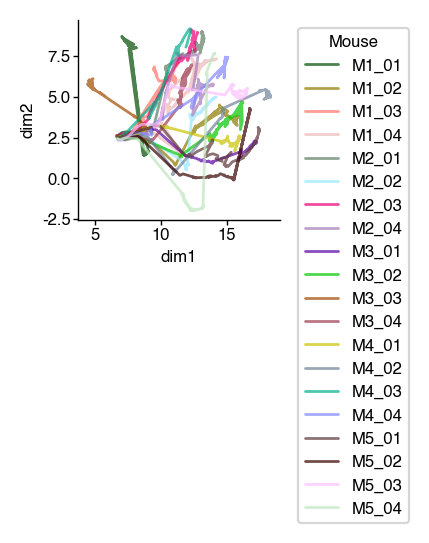

In [18]:
# Create a dictionary to map mouse IDs to colors
mouse_colors = dict(zip(pcs['mouse'].unique(), mmap))

# Set the size of the plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)

# Ensure that 'mouse' column is treated as a category for better handling
pcs['mouse'] = pcs['mouse'].astype('category')

# Apply a rolling window to smooth the data and plot lines for each mouse
for mouse_id in pcs['mouse'].unique():
    mouse_data = pcs[pcs['mouse'] == mouse_id]
    mouse_data = mouse_data.sort_values(by='age')  # Sort by 'age' for rolling window
    ax.plot(mouse_data['dim1'], mouse_data['dim2'], label=mouse_id, color=mouse_colors[mouse_id], alpha=0.7, linewidth=1)

# Customize the plot
sns.despine()
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend(title='Mouse', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [19]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_male_indv_longv2_n30_traj_unsmooth.pdf')

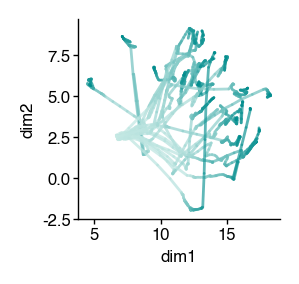

In [20]:
# Define the colormap for ages
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=pcs['age'].min(), vmax=pcs['age'].max())
cmap = cmm
import matplotlib.cm as cm

# Set the size of the plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)

# Ensure that 'mouse' column is treated as a category for better handling
pcs['mouse'] = pcs['mouse'].astype('category')

# Apply a rolling window to smooth the data
smoothed_data = []

for mouse_id in pcs['mouse'].unique():
    mouse_data = pcs[pcs['mouse'] == mouse_id]
    mouse_data = mouse_data.sort_values(by='age')  # Sort by 'age' for rolling window
    mouse_data['dim1_smooth'] = mouse_data['dim1'].rolling(window=4, min_periods=1).mean()
    mouse_data['dim2_smooth'] = mouse_data['dim2'].rolling(window=4, min_periods=1).mean()
    smoothed_data.append(mouse_data)

# Concatenate all smoothed data
smoothed_data = pd.concat(smoothed_data)

# Plot each line segment with gradient colors based on age
for mouse_id in smoothed_data['mouse'].unique():
    mouse_data = smoothed_data[smoothed_data['mouse'] == mouse_id]
    points = mouse_data[['dim1_smooth', 'dim2_smooth']].values
    ages = mouse_data['age'].values
    for i in range(len(points) - 1):
        segment = points[i:i+2]
        age_norm = norm(ages[i])
        color = cmap(age_norm)
        ax.plot(segment[:, 0], segment[:, 1], color=color, linewidth=1, alpha=0.7)

# Customize the plot
sns.despine()
plt.xlabel('dim1')
plt.ylabel('dim2')
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Age')

# Show the plot
plt.show()

In [21]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_male_age_longv2_n30_traj.pdf')

In [22]:
## for females:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


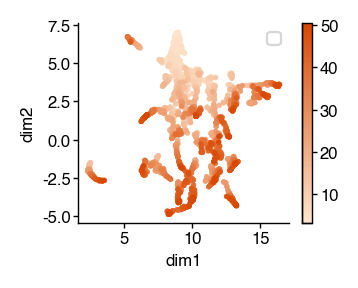

In [23]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming df contains your data
# Perform UMAP dimensionality reduction
#df=f_norm.copy()
df=f_df.copy()
reducer = umap.UMAP(random_state=0,n_neighbors=30)
umap_result = reducer.fit_transform(df)

pcs = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs['age'] = df.index.get_level_values('age')
pcs['mouse'] = df.index.get_level_values('mouse')
age_pc = pcs.drop('mouse', axis=1).groupby('age').mean()

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.7, 1.3)

# Scatter plot
im = ax.scatter(
    x=pcs['dim1'], y=pcs['dim2'], 
    c=pcs['age'], 
    cmap=cmf,
    s=3,
    linewidth =0.25,
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [10,20,30,40,50]

# Customize the plot
sns.despine()
#plt.title('UMAP Plot of Data females')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend()
plt.show()

In [24]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_female_age_longv2.pdf')

/tmp/ipykernel_15661/1899901673.py:4: UserWarning: The palette list has more values (20) than needed (19), which may not be intended.
  im=sns.scatterplot(data=pcs, x='dim1',y='dim2',hue='mouse',palette=fmap, legend=False, s=3, edgecolor='none')


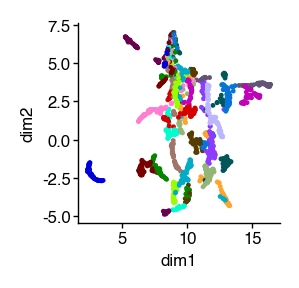

In [25]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)
im=sns.scatterplot(data=pcs, x='dim1',y='dim2',hue='mouse',palette=fmap, legend=False, s=3, edgecolor='none')
#cb = fig.colorbar(im, ax=ax)
#plt.title('UMAP Plot of Data females')

sns.despine()

In [26]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_female_indv_longv2.pdf')

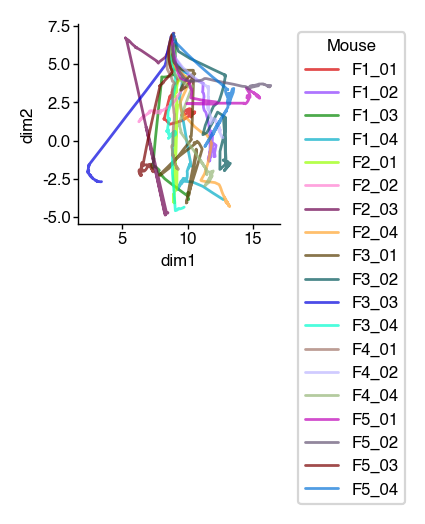

In [27]:
# Create a dictionary to map mouse IDs to colors
mouse_colors = dict(zip(pcs['mouse'].unique(), fmap))

# Set the size of the plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)

# Ensure that 'mouse' column is treated as a category for better handling
pcs['mouse'] = pcs['mouse'].astype('category')

# Apply a rolling window to smooth the data and plot lines for each mouse
for mouse_id in pcs['mouse'].unique():
    mouse_data = pcs[pcs['mouse'] == mouse_id]
    mouse_data = mouse_data.sort_values(by='age')  # Sort by 'age' for rolling window
    mouse_data['dim1_smooth'] = mouse_data['dim1'].rolling(window=4, min_periods=1).mean()
    mouse_data['dim2_smooth'] = mouse_data['dim2'].rolling(window=4, min_periods=1).mean()
    ax.plot(mouse_data['dim1_smooth'], mouse_data['dim2_smooth'], label=mouse_id, color=mouse_colors[mouse_id], alpha=0.7, linewidth=1)

# Customize the plot
sns.despine()
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend(title='Mouse', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [28]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_female_indv_longv2_traj.pdf')

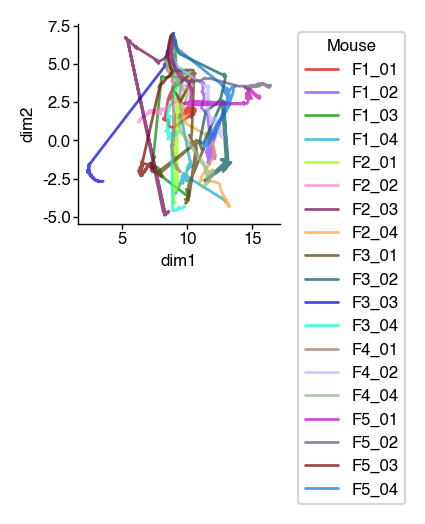

In [29]:
# Create a dictionary to map mouse IDs to colors
mouse_colors = dict(zip(pcs['mouse'].unique(), fmap))

# Set the size of the plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)

# Ensure that 'mouse' column is treated as a category for better handling
pcs['mouse'] = pcs['mouse'].astype('category')

# Apply a rolling window to smooth the data and plot lines for each mouse
for mouse_id in pcs['mouse'].unique():
    mouse_data = pcs[pcs['mouse'] == mouse_id]
    mouse_data = mouse_data.sort_values(by='age')  # Sort by 'age' for rolling window
    ax.plot(mouse_data['dim1'], mouse_data['dim2'], label=mouse_id, color=mouse_colors[mouse_id], alpha=0.7, linewidth=1)

# Customize the plot
sns.despine()
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend(title='Mouse', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [30]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_female_indv_longv2_traj_unsmooth.pdf')

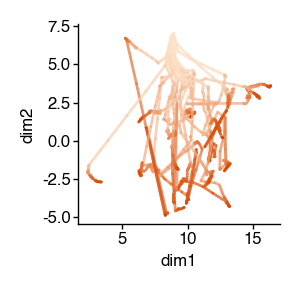

In [31]:
# Define the colormap for ages
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=pcs['age'].min(), vmax=pcs['age'].max())
cmap = cmf
import matplotlib.cm as cm

# Set the size of the plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1.3)

# Ensure that 'mouse' column is treated as a category for better handling
pcs['mouse'] = pcs['mouse'].astype('category')

# Apply a rolling window to smooth the data
smoothed_data = []

for mouse_id in pcs['mouse'].unique():
    mouse_data = pcs[pcs['mouse'] == mouse_id]
    mouse_data = mouse_data.sort_values(by='age')  # Sort by 'age' for rolling window
    mouse_data['dim1_smooth'] = mouse_data['dim1'].rolling(window=4, min_periods=1).mean()
    mouse_data['dim2_smooth'] = mouse_data['dim2'].rolling(window=4, min_periods=1).mean()
    smoothed_data.append(mouse_data)

# Concatenate all smoothed data
smoothed_data = pd.concat(smoothed_data)

# Plot each line segment with gradient colors based on age
for mouse_id in smoothed_data['mouse'].unique():
    mouse_data = smoothed_data[smoothed_data['mouse'] == mouse_id]
    points = mouse_data[['dim1_smooth', 'dim2_smooth']].values
    ages = mouse_data['age'].values
    for i in range(len(points) - 1):
        segment = points[i:i+2]
        age_norm = norm(ages[i])
        color = cmap(age_norm)
        ax.plot(segment[:, 0], segment[:, 1], color=color, linewidth=1, alpha=0.7)

# Customize the plot
sns.despine()
plt.xlabel('dim1')
plt.ylabel('dim2')
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
#cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Age')

# Show the plot
plt.show()

In [32]:
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig3"/ 'UMAP_female_age_longv2_traj.pdf')